Блокнот по видео [Diffusion models from scratch in PyTorch](https://youtu.be/a4Yfz2FxXiY?si=ONoYp-w4-qlJYd5G)

Изучаю датасет

Как датасет буду использовать свой - спаршеные картинки аянами рей

In [1]:
import math

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch.optim import Adam

import torchvision
from torchvision import transforms

import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True  # Игнорировать обрезанные изображения

In [2]:
def show_images(dataset, num_samples=20, cols=4):
    '''Plots samples from the dataset'''
    plt.figure(figsize=(15, 15))
    num_samples = min(num_samples, len(dataset))
    
    for i in range(num_samples):
        # Получаем изображение и метку
        img_tensor, _ = dataset[i]
        
        # 1. Преобразуем тензор в numpy-массив
        # 2. Меняем порядок осей: (C, H, W) -> (H, W, C)
        # 3. Денормализуем изображение
        img = img_tensor.numpy().transpose(1, 2, 0)
        img = img * np.array([0.5, 0.5, 0.5]) + np.array([0.5, 0.5, 0.5])
        img = np.clip(img, 0, 1)  # Ограничиваем значения [0, 1]
        
        # Создаем подграфик
        plt.subplot(int(np.ceil(num_samples / cols)), cols, i + 1)
        plt.imshow(img)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

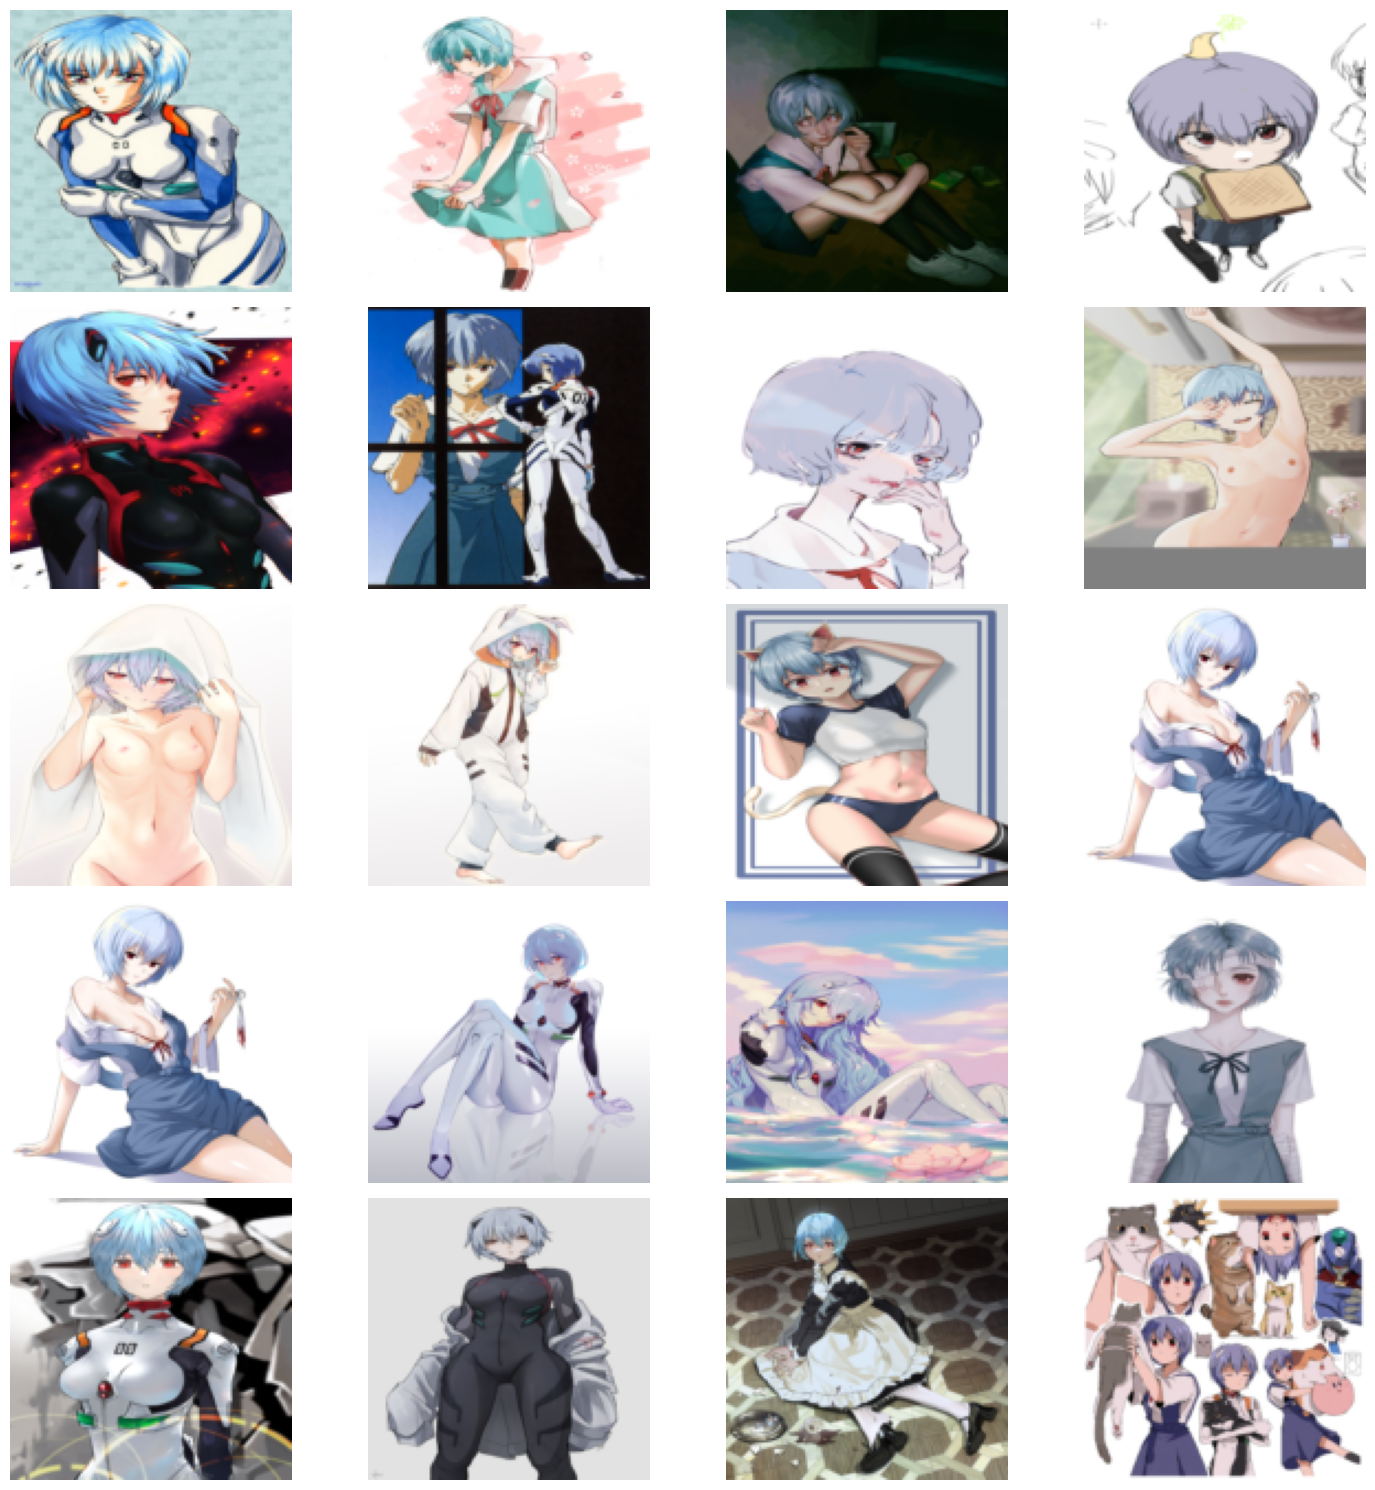

In [3]:
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5,0.5,0.5])
])

data = torchvision.datasets.ImageFolder(root='images', transform=transform)
show_images(data)

## Шаг 1 - прямой процесс

Для начала надо построить инпуты для модели, которыми являются все более и более зашумленные фотографии. Вместо того чтобы делать это последовательно, можно сделать функцию которая будет расчитывать фотографию с любым шагом

In [4]:
def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)

In [5]:
# Определяем beta shedule
T = 300
betas = linear_beta_schedule(timesteps=T)


# Пре-подсчитанные значения
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1,0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0/alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1.-alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

In [6]:
def get_index_from_list(vals, t, x_shape):
    '''
    Возвращает определенный индекс t передаваемого списка значений
    пока расчитывается батчевое пространство
    '''
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, device='cpu'):
    ''' 
    Берет изображение и шаг как инпут,
    и возврщает зашумленную версию
    '''

    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)



Попробуем на нашем датасете

In [7]:
IMG_SIZE = 128
BATCH_SIZE = 32

def load_transformed_dataset():
    transform = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Lambda(lambda t: (t*2)-1)
    ])
    return torchvision.datasets.ImageFolder(root='images', transform=transform)

def show_tensor_images(image):
    reverse_transform = transforms.Compose([
        transforms.Lambda(lambda t: (t+1) / 2),
        transforms.Lambda(lambda t: t.permute(1,2,0)),
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage()

    ])
    # Берем первое изображения из батча
    if len(image.shape) == 4:
        image = image[0, :, :, :]
    plt.imshow(reverse_transform(image))

In [8]:
data = load_transformed_dataset()
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

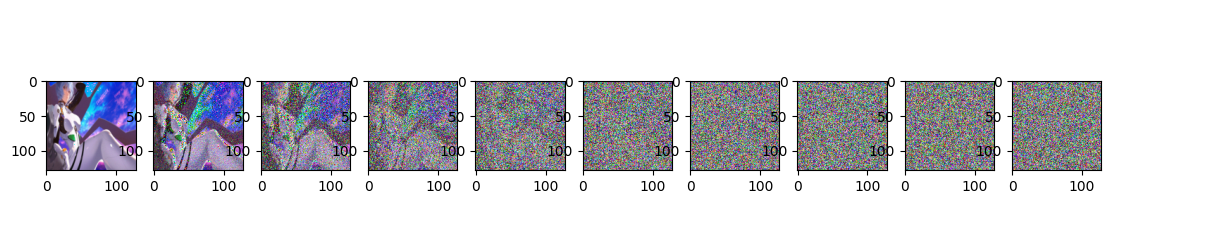

In [9]:
# Симулируем прямое зашумление
image = next(iter(dataloader))[0]

plt.figure(figsize=(15,3))
plt.axis('off')
num_images = 10
stepsize = int(T/num_images)

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images+1, int(idx/stepsize)+1)
    img, noise = forward_diffusion_sample(image, t)
    show_tensor_images(img)

## Шаг 2 - обратный процесс = U-Net

In [10]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp = nn.Linear(time_emb_dim, out_ch)

        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)

        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU()

    def forward(self, x, t):
        # Первый слой
        h = self.bnorm1(self.relu(self.conv1(x)))
        # Временной эмбеддинг
        time_emb = self.relu(self.time_mlp(t))
        # Расширяем последние 2 измерения
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # Добавляем канал времени
        h = h + time_emb
        # Второй слой
        h = self.bnorm2(self.relu(self.conv2(h)))
        return self.transform(h)
    
class SinusoidalPositionEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2

        embeddings = math.log(10000) / (half_dim-1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=1)
        return embeddings
    

class SimpleUnet(nn.Module):
    ''' 
    Упрощенный вариант архитектуры U-Net
    '''
    def __init__(self):
        super().__init__()
        image_channels = 3
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 3
        time_emb_dim = 32

        # Эмбеддинг времени
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbedding(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.ReLU()
        )

        # Инициация проекции
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)
        # Downsample
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], 
                                          time_emb_dim) 
                                    for i in range(len(down_channels)-1)])
        
        # Upsample
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], 
                                          time_emb_dim, up=True) 
                                    for i in range(len(down_channels)-1)])
        
        self.output = nn.Conv2d(up_channels[-1], out_dim, 1)

    def forward(self, x, timestep):
        t = self.time_mlp(timestep)
        x = self.conv0(x)
        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            x = torch.cat((x, residual_x), dim=1)
            x = up(x, t)
        return self.output(x)
    


model = SimpleUnet()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Num params: {sum(p.numel() for p in model.parameters())}')
model
        


Num params: 62438883


SimpleUnet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbedding()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=32, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Block(
      (time_mlp): Linear(in_features=32, out_features=256, bias=True)
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform

## Шаг 3 - The Loss

In [11]:
def get_loss(model, x_0, t):
    x_noisy, noise = forward_diffusion_sample(x_0, t, device)
    noise_pred = model(x_noisy, t)
    return F.l1_loss(noise, noise_pred)

## Сэмплирование

In [12]:
@torch.no_grad()
def sample_timestep(x, t):
    ''' 
    Вызывает модель для предсказывания шума на изображении
    и возвращает разшумленное изображение
    Добавляет шум к фото, если это не последняя эпоха (шаг)
    '''
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(
        sqrt_recip_alphas, t, x.shape
    )
    # Вызываем модель (текущее фото - предсказанный шум)
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x,t) / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)

    if t == 0:
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise
    
@torch.no_grad()
def sample_plot_image():
    # Сэмпл шума
    img_size = IMG_SIZE
    img = torch.randn((1, 3, img_size, img_size), device=device)
    plt.figure(figsize=(15,2))
    plt.axis('off')
    num_images = 10
    stepsize = int(T/num_images)

    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t)
        img = torch.clamp(img, -1.0, 1.0)
        if i % stepsize == 0:
            plt.subplot(1, num_images, int(i/stepsize)+1)
            show_tensor_images(img.detach().cpu())
    plt.show()

In [13]:
@torch.no_grad()
def sample_plot_image_tensorboard():
    img_size = IMG_SIZE
    img = torch.randn((1, 3, img_size, img_size), device=device)
    num_images = 10
    stepsize = int(T / num_images)

    all_imgs = []

    for i in range(T - 1, -1, -1):
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t)
        img = torch.clamp(img, -1.0, 1.0)

        if i % stepsize == 0:
            # Подготовка изображения для TensorBoard (только первое изображение в батче)
            img_cpu = img[0].detach().cpu()
            img_cpu = (img_cpu + 1) / 2  # [-1, 1] -> [0, 1]
            all_imgs.append(img_cpu)

    # Объединяем картинки в один тензор (для 1x10 картинки)
    grid = torch.stack(all_imgs, dim=0)
    return torchvision.utils.make_grid(grid, nrow=len(all_imgs))

In [14]:
from torch.utils.data import random_split

data = load_transformed_dataset()
train_size = int(0.9 * len(data))
val_size = len(data) - train_size
train_data, val_data = random_split(data, [train_size, val_size])
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)


In [15]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

patience = 5
early_stopping_counter = 0
best_val_loss = float("inf")
optimizer = Adam(model.parameters(), lr=0.001)

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)


In [16]:
@torch.no_grad()
def evaluate(model, dataloader):
    model.eval()
    total_loss = 0
    for batch in dataloader:
        images = batch[0].to(device)
        t = torch.randint(0, T, (images.size(0),), device=device).long()
        loss = get_loss(model, images, t)
        total_loss += loss.item()
    return total_loss / len(dataloader)


## Тренировка

In [17]:


best_loss = float("inf")
writer = SummaryWriter(log_dir="runs/diffusion_ayaka")
model.to(device)
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 50
global_step = 0

In [18]:
for epoch in range(epochs):
    model.train()
    epoch_bar = tqdm(train_loader, desc=f"[Epoch {epoch+1}/{epochs}]", leave=True)
    epoch_loss = 0

    for step, batch in enumerate(epoch_bar):
        optimizer.zero_grad()
        images = batch[0].to(device)
        t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
        loss = get_loss(model, images, t)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        global_step += 1
        writer.add_scalar("Loss/train_step", loss.item(), global_step)
        epoch_bar.set_postfix(loss=loss.item())

    # Средний лосс за эпоху
    avg_train_loss = epoch_loss / len(train_loader)
    writer.add_scalar("Loss/train_epoch", avg_train_loss, epoch)
    print(f"[Epoch {epoch+1}] Train Loss: {avg_train_loss:.6f}")

    # Валидация
    val_loss = evaluate(model, val_loader)
    writer.add_scalar("Loss/val", val_loss, epoch)
    print(f"[Epoch {epoch+1}] Val Loss: {val_loss:.6f}")

    # Scheduler update
    scheduler.step(val_loss)

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pt")
        print(f"✓ Сохранили модель с новым лучшим Val Loss = {best_val_loss:.6f}")
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        print(f"✗ Val Loss не улучшился ({early_stopping_counter}/{patience})")
        if early_stopping_counter >= patience:
            print("⛔ Early stopping: модель больше не улучшается")
            break

    # Сэмплирование изображений
    if (epoch + 1) % 10 == 0:
        sampled_grid = sample_plot_image_tensorboard()
        writer.add_image("Samples", sampled_grid, epoch + 1)


[Epoch 1/50]:   0%|          | 0/21 [00:04<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(), 'unet-5ep.pth')

In [18]:
model = SimpleUnet()  # или UNet, в зависимости от твоей модели
model.load_state_dict(torch.load("best_model.pt"))
model.eval()

SimpleUnet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbedding()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=32, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Block(
      (time_mlp): Linear(in_features=32, out_features=256, bias=True)
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform

In [19]:
@torch.no_grad()
def sample_plot_image(save_path=None):
    model.eval()
    img_size = IMG_SIZE
    img = torch.randn((1, 3, img_size, img_size), device=device)
    plt.figure(figsize=(15, 2))
    plt.axis('off')
    num_images = 10
    stepsize = int(T / num_images)

    for i in reversed(range(0, T)):
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t)
        img = torch.clamp(img, -1.0, 1.0)

        if i % stepsize == 0:
            plt.subplot(1, num_images, int(i / stepsize) + 1)
            show_tensor_images(img.detach().cpu())

    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()


In [25]:
sampled_grid = sample_plot_image_tensorboard()
writer.add_image("Samples", sampled_grid, epoch + 1)

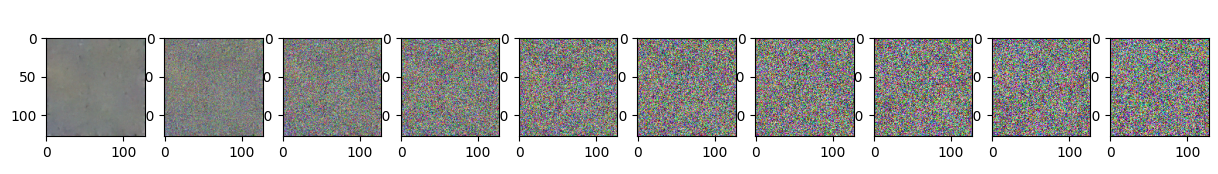

In [20]:
sample_plot_image("generated_epoch_final.png")


MSE: 0.0379381887614727


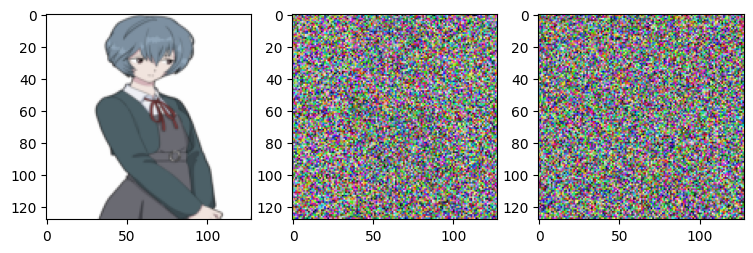

In [21]:
# Используем реальные изображения и шум
x0, _ = next(iter(dataloader))
x0 = x0.to(device)
t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()

x_noisy, noise = forward_diffusion_sample(x0, t)
noise_pred = model(x_noisy, t)

# Сравним предсказанный и настоящий шум
print("MSE:", F.mse_loss(noise_pred, noise).item())

# Визуализируем результат
plt.figure(figsize=(9,3))
for i, img in enumerate([x0[0], x_noisy[0], noise_pred[0]]):
    plt.subplot(1, 3, i+1)
    show_tensor_images(img.detach().cpu())
plt.show()


In [22]:
import matplotlib.animation as animation
from IPython.display import HTML

@torch.no_grad()
def create_diffusion_animation(model, steps=T, img_size=IMG_SIZE, save_path=None):
    model.eval()
    fig = plt.figure(figsize=(3, 3))
    plt.axis('off')

    x = torch.randn((1, 3, img_size, img_size), device=device)
    ims = []

    for i in reversed(range(steps)):
        t = torch.full((1,), i, device=device, dtype=torch.long)
        x = sample_timestep(x, t)
        x = torch.clamp(x, -1, 1)

        img = x[0].detach().cpu()
        img = (img + 1) / 2  # денормализация
        img = img.permute(1, 2, 0).numpy()

        im = plt.imshow(img, animated=True)
        ims.append([im])

    ani = animation.ArtistAnimation(fig, ims, interval=20, blit=True, repeat_delay=1000)
    
    if save_path:
        ani.save(save_path, writer='pillow', fps=30)
        print(f"Saved to {save_path}")
    else:
        return HTML(ani.to_jshtml())


Saved to diffusion.gif


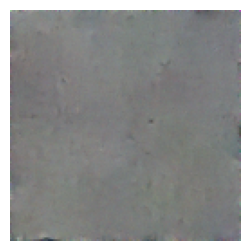

In [23]:
create_diffusion_animation(model, save_path="diffusion.gif")
